# RQ2: Como o sentimento afeta o engajamento dos usuários, especialmente novatos?

In [ ]:
import helper
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [ ]:
# Get post + user data
post_data = helper.load_post_data('./data/analyzed.jsonl')
user_data = helper.load_user_data('./data/dump-users.json')

In [3]:
users_average_sentiment = helper.get_users_average_sentiment(post_data)

Text(0.5, 1.0, "Distribution of Users' Average Sentiment")

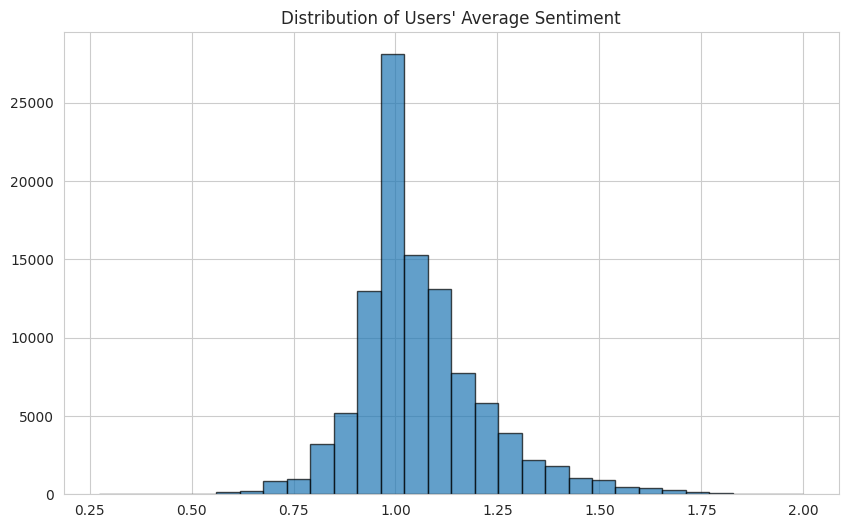

In [ ]:
sentiment_values = [sentiment for user_id, sentiment in users_average_sentiment.items() if user_id is not None]

plt.figure(figsize=(10, 6))
plt.hist(sentiment_values, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Users\' Average Sentiment')

/tmp/ipykernel_47141/2042327201.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('Reputation_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])


Text(0, 0.5, 'Average Sentiment')

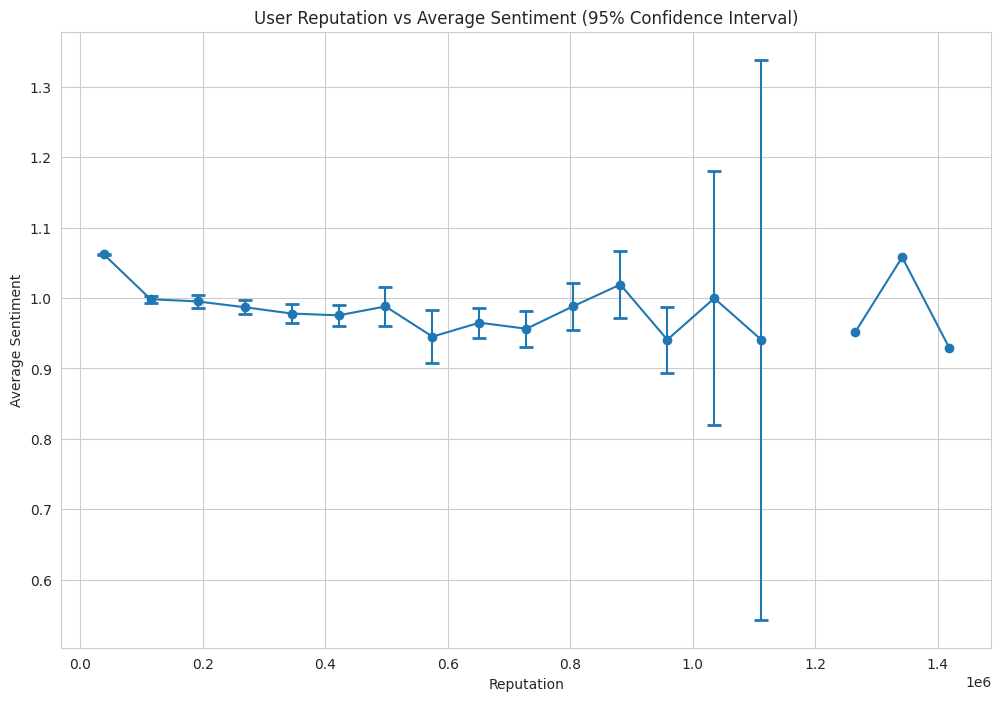

In [22]:
user_reputation = {user_id: user['reputation'] for user_id, user in user_data.items() if user_id in users_average_sentiment and 'reputation' in user}

df = pd.DataFrame({
    'User ID': list(user_reputation.keys()),
    'Reputation': list(user_reputation.values()),
    'Average Sentiment': [users_average_sentiment[user_id] for user_id in user_reputation.keys()]
})

bins = np.linspace(df['Reputation'].min(), df['Reputation'].max(), 20)
df['Reputation_Binned'] = pd.cut(df['Reputation'], bins)
binned_stats = df.groupby('Reputation_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])

confidence_level = 0.95
alpha = 1 - confidence_level
bin_centers = [(interval.left + interval.right) / 2 for interval in binned_stats.index]

standard_errors = binned_stats['std'] / np.sqrt(binned_stats['count'])
degrees_freedom = binned_stats['count'] - 1
t_critical = [stats.t.ppf(1 - alpha/2, df) for df in degrees_freedom]
margin_of_error = standard_errors * t_critical

plt.figure(figsize=(12, 8))
plt.errorbar(bin_centers, binned_stats['mean'], yerr=margin_of_error, 
            fmt='o-', capsize=5, capthick=2, markersize=6)
plt.title('User Reputation vs Average Sentiment (95% Confidence Interval)')
plt.xlabel('Reputation')
plt.ylabel('Average Sentiment')

/tmp/ipykernel_47141/332638016.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('Period_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])


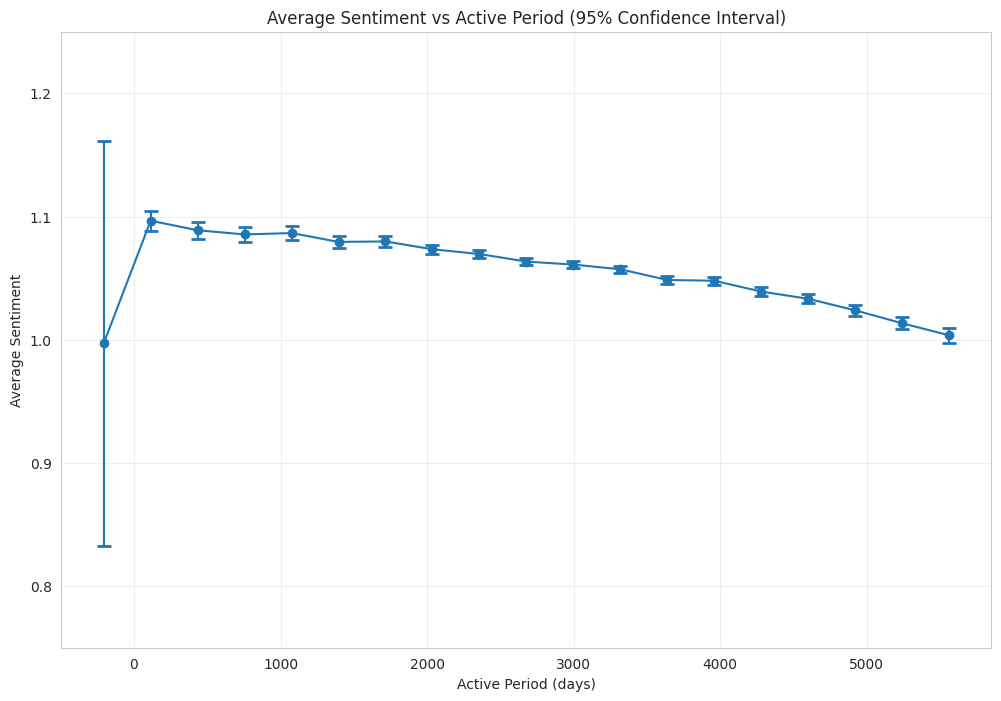

In [ ]:
user_active_period = {user_id: (user['last_interaction'] - user['creation_date']).days 
                      for user_id, user in user_data.items()}
df['Active Period (days)'] = [user_active_period[user_id] for user_id in df['User ID'] if user_id in user_active_period]

bins = np.linspace(df['Active Period (days)'].min(), df['Active Period (days)'].max(), 20)
df['Period_Binned'] = pd.cut(df['Active Period (days)'], bins)
binned_stats = df.groupby('Period_Binned')['Average Sentiment'].agg(['mean', 'std', 'count'])

confidence_level = 0.95
alpha = 1 - confidence_level
bin_centers = [(interval.left + interval.right) / 2 for interval in binned_stats.index]

standard_errors = binned_stats['std'] / np.sqrt(binned_stats['count'])
degrees_freedom = binned_stats['count'] - 1
t_critical = [stats.t.ppf(1 - alpha/2, df) for df in degrees_freedom]
margin_of_error = standard_errors * t_critical

plt.figure(figsize=(12, 8))
plt.errorbar(bin_centers, binned_stats['mean'], yerr=margin_of_error, 
            fmt='o-', capsize=5, capthick=2)
plt.title('Average Sentiment vs Active Period (95% Confidence Interval)')
plt.xlabel('Active Period (days)')
plt.ylabel('Average Sentiment')
plt.ylim(0.75, 1.25)
plt.show()

## Como o **sentimento de um post** (pergunta ou resposta) afeta seu engajamento em termos dos comentários e do seu score?

TODO - acho que a distribuicao de scores/comentarios por sentimento apenas das respostas é diferente no das questões

ver tbm os sentimentos dos comentarios


In [62]:
parsed = {'scores': [[], [], []], 'num_comments': [[], [], []]}

def collect_post_data(post):
    sent = post['body_sentiment']

    parsed['scores'][sent].append(post['score'])
    parsed['num_comments'][sent].append(len(post['comments']))

    #Recursively add data
    if 'answers' in post:
        for a in post['answers']: collect_post_data(a)

#Run for prominent data
for id, post in post_data.items():
    collect_post_data(post)

Text(0.5, 1.0, 'Number of comments per post sentiment')

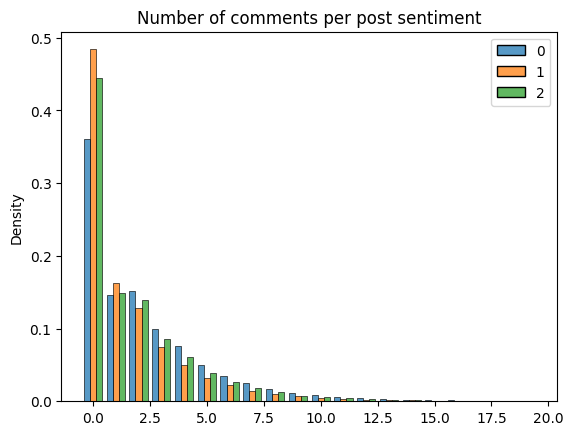

In [64]:
filter = [[x for x in l if x < 20] for l in parsed['num_comments']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Number of comments per post sentiment')

Text(0.5, 1.0, 'Score per post sentiment')

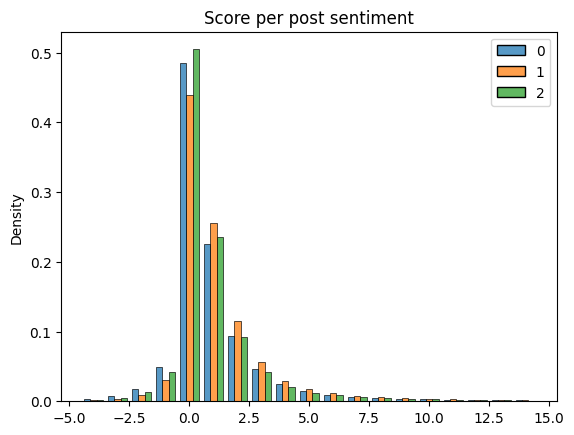

In [67]:
filter = [[x for x in l if -5 < x < 15] for l in parsed['scores']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Score per post sentiment')

## Analisando engajamento em torno do sentimento da **pergunta original**:

- [x] Número de respostas dado o sentimento da questão original -> A distribuição é a mesma
- [x] Score da pergunta dado o sentimento mínimo da pergunta -> Leve diferença (ver histograma)
- [x] Tempo de resposta mínimo dependendo do sentimento da questão original -> Leve diferença (ver boxplot)

In [ ]:
ans = {'unanswered': [0,0,0], 'total': [0,0,0], 
       'response_times': [[], [], []], 'num_answers': [[], [], []], 
       'scores': [[], [], []], 'num_comments': [[],[],[]]}

for id, post in post_data.items():
    #Check question sentiment
    q_sent = post['body_sentiment']

    ans['total'][q_sent] += 1
    ans['num_answers'][q_sent].append(len(post['answers']))
    ans['scores'][q_sent].append(post['score'])

    ans['num_comments'][q_sent].append(len(post['comments']))
    
    if len(post['answers']) == 0: ans['unanswered'][q_sent] += 1
    else:
        quickest = (min([a['creation_date'] for a in post['answers']]) - post['creation_date'])
        ans['response_times'][q_sent].append(quickest.seconds / 3600)

In [4]:
print('Number of question for each answer:', ans['total'])

print('Number of unanswered question per question sentiment:')

for u,t in zip(ans['unanswered'], ans['total']):
    print(u / t)

print('Metric: Amount of anwers per question sentiment')
print('Mean', [float(np.mean(a)) for a in ans['num_answers']])
print('Standard deviation:', [float(np.std(a)) for a in ans['num_answers']])

print('\nMetric: Question score per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['scores']])
print('Standard deviation:', [float(np.std(a)) for a in ans['scores']])

print('\nMetric: Response time per question sentiment')
print('Mean:', [float(np.mean(a)) for a in ans['response_times']])
print('Standard deviation:', [float(np.std(a)) for a in ans['response_times']])

Number of question for each answer: [120803, 720892, 158305]
Number of unanswered question per question sentiment:
0.14792678989760188
0.14028176203925138
0.14839076466315024
Metric: Amount of anwers per question sentiment
Mean [1.3536998253354635, 1.339779051508409, 1.299655727867092]
Standard deviation: [1.2015125090161722, 1.1515028855277245, 1.039488274165542]

Metric: Question score per question sentiment
Mean: [1.3843613155302434, 1.4315445309422217, 0.9691481633555479]
Standard deviation: [9.173996349083579, 10.303536846208223, 4.865474532057022]

Metric: Response time per question sentiment
Mean: [3.7243113130763588, 3.9938617876231026, 4.071148335237191]
Standard deviation: [6.14632485563535, 6.278911002127294, 6.3315843155574125]


<Axes: >

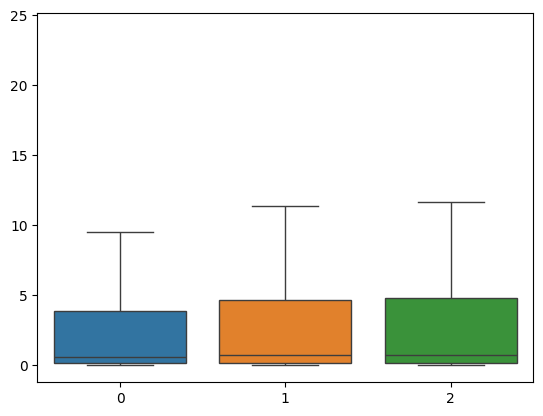

In [ ]:
sns.boxplot(ans['response_times'], fliersize=False)

Text(0.5, 1.0, 'Question score per sentiment')

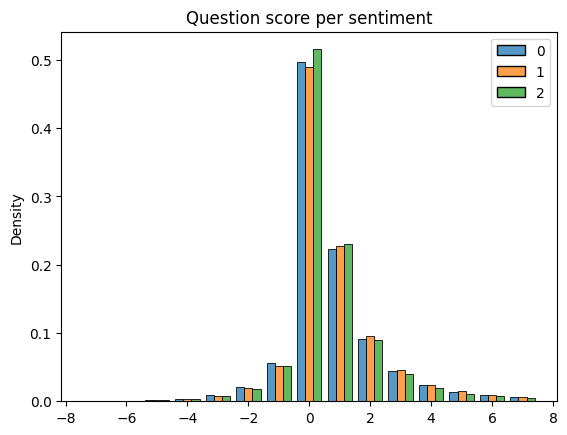

In [49]:
filter = [[x for x in l if -8 < x < 8] for l in ans['scores']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Question score per sentiment')

Text(0.5, 1.0, 'Number of comments per question sentiment')

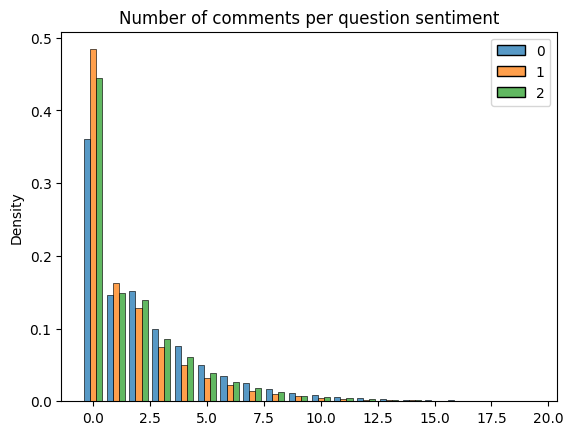

In [56]:
filter = [[x for x in l if x < 20] for l in ans['num_comments']]

sns.histplot(filter, stat='density', discrete=True, multiple='dodge', shrink=0.8, common_norm=False)
plt.title('Number of comments per question sentiment')